In [68]:
import os
import sys
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from skimage.util import random_noise
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import torch.optim as optim
from skimage.metrics import structural_similarity as ssim
import random
import shutil
from bm3d import bm3d, BM3DProfile



# if crop the image

In [67]:
def autocrop_and_resize_image(image_path, output_path, size=(1500, 1000), threshold=20):
    """
    Autocrops an image to remove black padding and resizes it.
    
    Args:
    - image_path (str): Path to the input image.
    - output_path (str): Path to save the processed image.
    - size (tuple): Target size to resize the image.
    - threshold (int): Threshold for detecting non-black pixels.
    """
    image = Image.open(image_path).convert('L')
    image_np = np.array(image)
    
    # Create a mask of non-black pixels (assuming black is near 0)
    mask = image_np > threshold
    
    # Find the bounding box of non-black pixels
    coords = np.argwhere(mask)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    
    # Crop the image to the bounding box
    cropped_image = image.crop((x_min, y_min, x_max + 1, y_max + 1))
    resized_image = cropped_image.resize(size, Image.LANCZOS)
    resized_image.save(output_path)

source_folder = 'dataset/source'
destination_folder = 'dataset/noblackpadding'
os.makedirs(destination_folder, exist_ok=True)
if False:
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            input_image_path = os.path.join(source_folder, filename)
            output_image_path = os.path.join(destination_folder, filename)
            autocrop_and_resize_image(input_image_path, output_image_path)

    destination_folder

    source_dir = 'dataset/source'
    noisy_dir = 'dataset/neverseen'

    # Create the destination directory if it doesn't exist
    os.makedirs(noisy_dir, exist_ok=True)

    # Get a list of all image files in the source directory
    image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]

    # Randomly select 49 images
    selected_images = random.sample(image_files, 18)

    # Move selected images to the noisy directory
    for image in selected_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(noisy_dir, image)
        shutil.move(src_path, dst_path)

    print(f"Successfully moved {len(selected_images)} images to the '{noisy_dir}' directory.")


In [3]:
if False:
    width, height = 2992, 2000

    save_dir = "dataset/source"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i in range(1001, 1049):
        black_image = np.zeros((height, width, 3), dtype=np.uint8)
        img = Image.fromarray(black_image)
        img.save(os.path.join(save_dir, f"{i}.jpg"))

    print("48 black images generated and saved successfully.")

# Net Structure Define

In [66]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class SimplifiedResNetDenoise(nn.Module):
    def __init__(self):
        super(SimplifiedResNetDenoise, self).__init__()
        self.in_channels = 8 # leave this to 8
        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(BasicBlock, self.in_channels, 1, stride=1)  
        """self.layer2 = self.make_layer(BasicBlock, self.in_channels * 2, 1, stride=2)
        self.layer3 = self.make_layer(BasicBlock, self.in_channels * 4, 1, stride=2)"""
        self.conv2 = nn.Conv2d(self.in_channels, 1, kernel_size=3, stride=1, padding=1, bias=False)
        #self.conv2 = nn.Conv2d(self.in_channels, 1, kernel_size=3, stride=1, padding=1, bias=False)  
        
    def make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        """out = self.layer2(out)
        out = self.layer3(out)"""
        out = self.conv2(out)
        return out




In [64]:
model

NameError: name 'model' is not defined

# metric for training performance

In [69]:
def calculate_psnr(gt, image, max_value=1):
    mse = F.mse_loss(gt, image)  # Calculate mean square error
    return 20 * torch.log10(max_value / torch.sqrt(mse))

def calculate_ssim(gt, image, data_range=255):
    try:
        return ssim(np.array(gt), np.array(image))
        """gt_squeezed = gt.squeeze()
        image_squeezed = image.squeeze() 
        if len(gt_squeezed.shape) == 3:
            gt_np = gt_squeezed.detach().cpu().numpy().transpose(1, 2, 0)  # from (C, H, W) to (H, W, C)
        else:
            print("gt shape")
            print(gt_squeezed.shape)
            print("gt size")
            print(len(gt_squeezed))
            #raise ValueError("gt_squeezed does not have 3 dimensions")
        if len(image_squeezed.shape) == 3:
            image_np = image_squeezed.detach().cpu().numpy().transpose(1, 2, 0)  # from (C, H, W) to (H, W, C)
        else:
            print("gt shape")
            print(image_squeezed.shape)
            print("gt size")
            print(len(image_squeezed))
            #raise ValueError("image_squeezed does not have 3 dimensions")

        min_size = min(gt_np.shape[:2])
        win_size = min(min_size if min_size % 2 == 1 else min_size - 1, 7)
        return ssim(gt_np, image_np, channel_axis=-1, win_size=win_size, data_range=data_range)"""
    except Exception as e:
        print(e)
        return 0.99

def subtract_images(image1, image2):
    """
    Subtracts one image from another and returns the result as a new image.
    
    Args:
    - image1 (PIL.Image): The first image.
    - image2 (PIL.Image): The second image.
    
    Returns:
    - PIL.Image: The resulting image after subtraction.
    """
    array1 = np.array(image1).astype(np.int16)
    array2 = np.array(image2).astype(np.int16)
    result_array = array1 - array2
    norm = Normalize(vmin=-255, vmax=255)
    normalized_result = norm(result_array)
    cmap = plt.get_cmap('bwr')
    colored_result = cmap(normalized_result)
    colored_image = Image.fromarray((colored_result[:, :, :3] * 255).astype(np.uint8))
    return colored_image

"""
for noisy_images, clean_images in train_loader:
    print(type(noisy_images))
    print(calculate_ssim(noisy_images, clean_images))
    
    to_pil = transforms.ToPILImage()
    noisy_pil_image = to_pil(noisy_images[0])
    noisy_pil_image.show()
    clean_pil_image = to_pil(clean_images[0])
    clean_pil_image.show()
    print(noisy_images.numpy().shape)
    print(ssim(noisy_images.numpy()[0, 0], clean_images.numpy()[0,0], data_range=255))
    print(calculate_ssim(clean_images.unsqueeze(0), noisy_images.unsqueeze(0)))"""
    


'\nfor noisy_images, clean_images in train_loader:\n    print(type(noisy_images))\n    print(calculate_ssim(noisy_images, clean_images))\n    \n    to_pil = transforms.ToPILImage()\n    noisy_pil_image = to_pil(noisy_images[0])\n    noisy_pil_image.show()\n    clean_pil_image = to_pil(clean_images[0])\n    clean_pil_image.show()\n    print(noisy_images.numpy().shape)\n    print(ssim(noisy_images.numpy()[0, 0], clean_images.numpy()[0,0], data_range=255))\n    print(calculate_ssim(clean_images.unsqueeze(0), noisy_images.unsqueeze(0)))'

# check GPU status

In [70]:
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Current CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

# Check GPU memory usage
def check_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0)
        reserved = torch.cuda.memory_reserved(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory
        free_memory = total_memory - reserved
        print(f"Total Memory: {total_memory / 1e9:.2f} GB     Allocated Memory: {allocated / 1e9:.2f} GB     Reserved Memory: {reserved / 1e9:.2f} GB     Free Memory: {free_memory / 1e9:.2f} GB")
    else:
        return "CUDA is not available."

gpu_memory_info = check_gpu_memory()

2.3.1+cu118
CUDA available: True
Current CUDA device name: NVIDIA GeForce RTX 4070 Laptop GPU
Total Memory: 8.59 GB     Allocated Memory: 0.00 GB     Reserved Memory: 0.00 GB     Free Memory: 8.59 GB


# noisy functionality

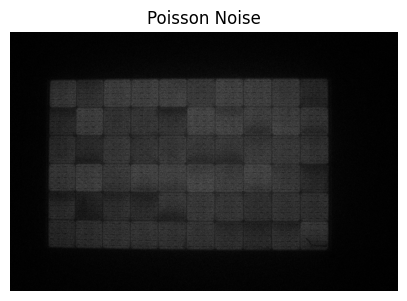

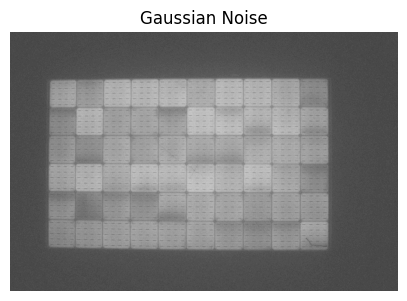

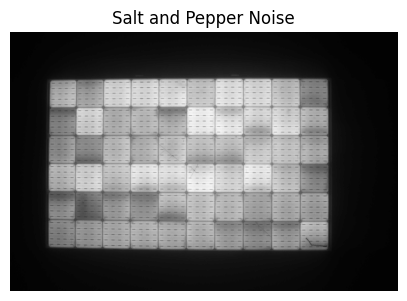

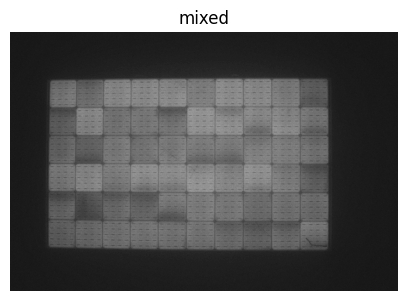

In [71]:

def add_poisson_noise_tensor(image_tensor, scale_factor=1e7):
    """
    Adds Poisson noise to a tensor image and returns the noise only.
    
    Args:
    - image_tensor (torch.Tensor): The input tensor image (C, H, W) with values in [0, 1].
    - scale_factor (float): The scale factor for Poisson noise. Default is 1e8.
    
    Returns:
    - torch.Tensor: The Poisson noise.
    """
    image_np = image_tensor.cpu().numpy()
    f = scale_factor / np.sum(image_np)     # Calculate the scaling factor based on the image
    noisy_image_np = np.random.poisson(f * image_np) / f     # Add Poisson noise
    noise_np = noisy_image_np - image_np     # Calculate the noise
    noise_tensor = torch.tensor(noise_np, dtype=torch.float32)
    return torch.tensor(noisy_image_np, dtype=torch.float32)

def add_gaussian_noise_tensor(image_tensor, mean=0.0, std=0.1):
    """
    Adds Gaussian noise to a tensor image and returns the noise only.
    
    Args:
    - image_tensor (torch.Tensor): The input tensor image (C, H, W) with values in [0, 1].
    - mean (float): The mean of the Gaussian noise.
    - std (float): The standard deviation of the Gaussian noise.
    
    Returns:
    - torch.Tensor: The Gaussian noise.
    """
    noise = torch.randn_like(image_tensor) * std + mean
    return noise+image_tensor

def add_salt_and_pepper_noise_tensor(image_tensor, salt_prob=0.0, pepper_prob=0.0):
    """
    Adds salt-and-pepper noise to a tensor image and returns the noise only.
    Args:
    - image_tensor (torch.Tensor): The input tensor image (C, H, W) with values in [0, 1].
    - salt_prob (float): Probability of adding salt noise.
    - pepper_prob (float): Probability of adding pepper noise.
    
    Returns:
    - torch.Tensor: The salt-and-pepper noise.
    """
    noisy_image_tensor = image_tensor.clone()
    noise_tensor = torch.zeros_like(image_tensor)
    num_salt = np.ceil(salt_prob * image_tensor.numel())
    num_pepper = np.ceil(pepper_prob * image_tensor.numel())
    # Add salt noise
    coords = [np.random.randint(0, i, int(num_salt)) for i in image_tensor.shape]
    noisy_image_tensor[coords] = 1
    noise_tensor[coords] = 1 - image_tensor[coords]
    # Add pepper noise
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image_tensor.shape]
    noisy_image_tensor[coords] = 0
    noise_tensor[coords] = -image_tensor[coords]
    
    return noisy_image_tensor

image_path = "dataset/source/14.jpg"
image = Image.open(image_path).convert('RGB')

# Convert the image to a tensor
transform = transforms.Compose([
    transforms.ToTensor()
])
image_tensor = transform(image)

# Add different types of noise
poisson_noise = add_poisson_noise_tensor(image_tensor)
gaussian_noise = add_gaussian_noise_tensor(image_tensor)
salt_and_pepper_noise = add_salt_and_pepper_noise_tensor(image_tensor)

# Convert to grayscale by averaging the channels
poisson_noise_gray = poisson_noise.mean(dim=0)
gaussian_noise_gray = gaussian_noise.mean(dim=0)
salt_and_pepper_noise_gray = salt_and_pepper_noise.mean(dim=0)

# Display the images separately with 'bwr' colormap
def display_image(noise_tensor, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_tensor.cpu().numpy(), cmap='grey')
    plt.title(title)
    plt.axis('off')
    plt.show()

display_image(poisson_noise_gray, 'Poisson Noise')
display_image(gaussian_noise_gray, 'Gaussian Noise')
display_image(salt_and_pepper_noise_gray, 'Salt and Pepper Noise')
display_image(poisson_noise_gray + gaussian_noise_gray + salt_and_pepper_noise_gray, 'mixed')


# setting before training

In [72]:
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model, define the loss function, and the optimizer
model = SimplifiedResNetDenoise().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()

decayRate = 0.96
my_lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=decayRate)

transform = transforms.Compose([
    transforms.Resize((2000, 2992)),
    transforms.ToTensor()  
])
batch_size = 11
class NoisyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)
        image = Image.open(image_path).convert('L')
        if self.transform:
            image = self.transform(image)
        noisy_image = self.add_noise(image, int(image_name.split(".jpg")[0]))
        noisy_image_pil = transforms.ToPILImage()(noisy_image)
        noisy_image_pil.save(os.path.join("dataset/neverseen_noised", image_name))
        return noisy_image, image
    def add_noise(self, image, number):
        #take image generate noisy mask like np.one
        #then multiply that array by the 
        #value between +1 and -1
        gau = add_gaussian_noise_tensor(image)  # Gaussian noise
        poi = add_poisson_noise_tensor(image) # Poission noise
        sap = add_salt_and_pepper_noise_tensor(image)  # Salt & Pepper noise
        image = image + gau + poi + sap
        image = torch.clamp(image, 0, 1)
        return image
    torch.cuda.empty_cache()


"""for i, (noisy_images, clean_images) in enumerate(val_loader):
    if i < 1:
        noisy_images = noisy_images.to(device)
        clean_images = clean_images.to(device)
        for j in range(min(4, noisy_images.size(0))):
            noisy_image = noisy_images
            clean_image = clean_images
            noisy_image = transforms.ToPILImage()(noisy_image[i])#Image.fromarray(noisy_image[j][0].cpu().numpy(), 'L')
            noisy_image.save(os.path.join("dataset/validation", f'{j}th_noisy.png'))
            clean_image = transforms.ToPILImage()(clean_image[j])#Image.fromarray(clean_image[j][0].cpu().numpy(), 'L')
            clean_image.save(os.path.join("dataset/validation", f'{j}th_clean.png'))
            print(calculate_ssim(noisy_image, clean_image))"""

train_dataset = NoisyDataset(root_dir='dataset/neverseen', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#model.load_state_dict(torch.load("resnet_denoise_model.pth"))
val_dataset = NoisyDataset(root_dir='dataset/temp_neverseen', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)




sample_image, _ = train_dataset[0]
image_dtype = sample_image.dtype
"""for noisy_images, clean_images in train_loader:
    noisy_images = noisy_images.to(device)
    clean_images = clean_images.to(device)"""
    #print(noisy_images.shape)
    #print(clean_images.shape)
    #print(calculate_ssim(clean_images, outputs))



'for noisy_images, clean_images in train_loader:\n    noisy_images = noisy_images.to(device)\n    clean_images = clean_images.to(device)'

# training

In [17]:
if False: # change to true if you want to train
    num_epochs = 50
    f = open('training_metrics.txt', 'w')
    f.write('Epoch,Batch,Loss,PSNR,SSIM\n')
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
            bn = 1
            for noisy_images, clean_images in train_loader:
                noisy_images = noisy_images.to(device)
                clean_images = clean_images.to(device)
                temp_psnr = 0
                temp_ssim = 0
                with autocast():
                    outputs = model(noisy_images)
                    loss = criterion(outputs, clean_images)
                    output_image = transforms.ToPILImage()(outputs[0])
                    clean_image = transforms.ToPILImage()(clean_images[0])
                    temp_psnr = calculate_psnr(outputs[0], clean_images[0])
                    temp_ssim = calculate_ssim(clean_image, output_image)
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                epoch_loss += loss.item()
                if bn % 10 == 0:
                    print(f"{epoch + 1},{bn},{loss.item()},{temp_psnr},{temp_ssim}\n")
                f.write(f"{epoch + 1},{bn},{loss.item()},{temp_psnr},{temp_ssim}\n")
                bn += 1
                pbar.update(1)

        torch.cuda.empty_cache()
        model.eval()
        total_psnr = 0
        total_ssim = 0
        n = 0
        with torch.no_grad():
            for i, (noisy_images, clean_images) in enumerate(val_loader):
                if i == 0:
                    noisy_images = noisy_images.to(device)
                    clean_images = clean_images.to(device)
                    outputs = model(noisy_images)
                    for j in range(min(4, noisy_images.size(0))):
                        n = n + 1
                        noisy_image = transforms.ToPILImage()(noisy_images[j])
                        clean_image = transforms.ToPILImage()(clean_images[j])
                        output_image = transforms.ToPILImage()(outputs[j])
                        total_psnr += calculate_psnr(outputs[j], clean_images[j])
                        total_ssim += calculate_ssim(clean_image, output_image)
                        diff_clean_noisy = subtract_images(noisy_image, clean_image)
                        diff_output_noisy = subtract_images(noisy_image, output_image)
                        output_image.save(os.path.join("dataset/validation/output", f'{epoch}th_epoch_{j}th_output.jpg'))
                        noisy_image.save(os.path.join("dataset/validation/noisy", f'{epoch}th_epoch_{j}th_noisy.jpg'))
                        diff_clean_noisy.save(os.path.join("dataset/validation", f'{epoch}th_epoch_{j}th_noisyclean.jpg'))
                        diff_output_noisy.save(os.path.join("dataset/validation", f'{epoch}th_epoch_{j}th_noisyoutput.jpg'))
        avg_psnr = total_psnr / n
        avg_ssim = total_ssim / n
        if epoch % 4 == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss / len(train_loader),
                    'scaler_state_dict': scaler.state_dict(),
                    }, f"Models/simple_network_{epoch}_in_{num_epochs}_checkpoints.pth")
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}')
        my_lr_scheduler.step()
        torch.cuda.empty_cache()



    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss / len(train_loader),
        'scaler_state_dict': scaler.state_dict(),
        }, f"Models/simple_network_{epoch}epoch.pth")

# I Chose a well performed checkpoints to keep training 

In [18]:
if True:
    # Define the necessary components (e.g., model, optimizer, criterion, scaler)
    model = SimplifiedResNetDenoise().to(device)  # or your specific model
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()
    temp_path = "simple_network_36_in_40_checkpoints.pth"
    checkpoint = torch.load(temp_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # if the scaler is loaded correctly then uncomment following
    # scaler.load_state_dict(checkpoint['scaler_state_dict']) # Uncomment if you saved the scaler state

    start_epoch = checkpoint['epoch']  # Start from the next epoch
    num_epochs = start_epoch + 14
    old_f = open('training_metrics.txt', 'w')
    for epoch in range(start_epoch, num_epochs):
        
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
            bn = 1
            for noisy_images, clean_images in train_loader:
                noisy_images = noisy_images.to(device)
                clean_images = clean_images.to(device)
                temp_psnr = 0
                temp_ssim = 0
                with autocast():
                    outputs = model(noisy_images)
                    loss = criterion(outputs, clean_images)
                    output_image = transforms.ToPILImage()(outputs[0])
                    clean_image = transforms.ToPILImage()(clean_images[0])
                    temp_psnr = calculate_psnr(outputs[0], clean_images[0])
                    temp_ssim = calculate_ssim(clean_image, output_image)
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                epoch_loss += loss.item()
                if bn % 10 == 0:
                    print(f"{epoch + 1},{bn},{loss.item()},{temp_psnr},{temp_ssim}\n")
                old_f.write(f"{epoch + 1},{bn},{loss.item()},{temp_psnr},{temp_ssim}\n")
                bn += 1
                pbar.update(1)

        torch.cuda.empty_cache()
        model.eval()
        total_psnr = 0
        total_ssim = 0
        n = 0
        with torch.no_grad():
            for i, (noisy_images, clean_images) in enumerate(val_loader):
                if i == 0:
                    noisy_images = noisy_images.to(device)
                    clean_images = clean_images.to(device)
                    outputs = model(noisy_images)
                    for j in range(min(4, noisy_images.size(0))):
                        n = n + 1
                        noisy_image = transforms.ToPILImage()(noisy_images[j])
                        clean_image = transforms.ToPILImage()(clean_images[j])
                        output_image = transforms.ToPILImage()(outputs[j])
                        total_psnr += calculate_psnr(outputs[j], clean_images[j])
                        total_ssim += calculate_ssim(clean_image, output_image)
                        diff_clean_noisy = subtract_images(noisy_image, clean_image)
                        diff_output_noisy = subtract_images(noisy_image, output_image)
                        output_image.save(os.path.join("dataset/validation/output", f'{epoch}th_epoch_{j}th_output.jpg'))
                        noisy_image.save(os.path.join("dataset/validation/noisy", f'{epoch}th_epoch_{j}th_noisy.jpg'))
                        diff_clean_noisy.save(os.path.join("dataset/validation", f'{epoch}th_epoch_{j}th_noisyclean.jpg'))
                        diff_output_noisy.save(os.path.join("dataset/validation", f'{epoch}th_epoch_{j}th_noisyoutput.jpg'))
        avg_psnr = total_psnr / n
        avg_ssim = total_ssim / n
        if epoch % 4 == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss / len(train_loader),
                    'scaler_state_dict': scaler.state_dict(),
                    }, f"Models/simple_network_{epoch}_in_{num_epochs}_checkpoints.pth")
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}')
    torch.cuda.empty_cache()

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss / len(train_loader),
        'scaler_state_dict': scaler.state_dict(),
        }, f"Models/simple_network_{num_epochs}.pth")

KeyboardInterrupt: 

# draw the training info

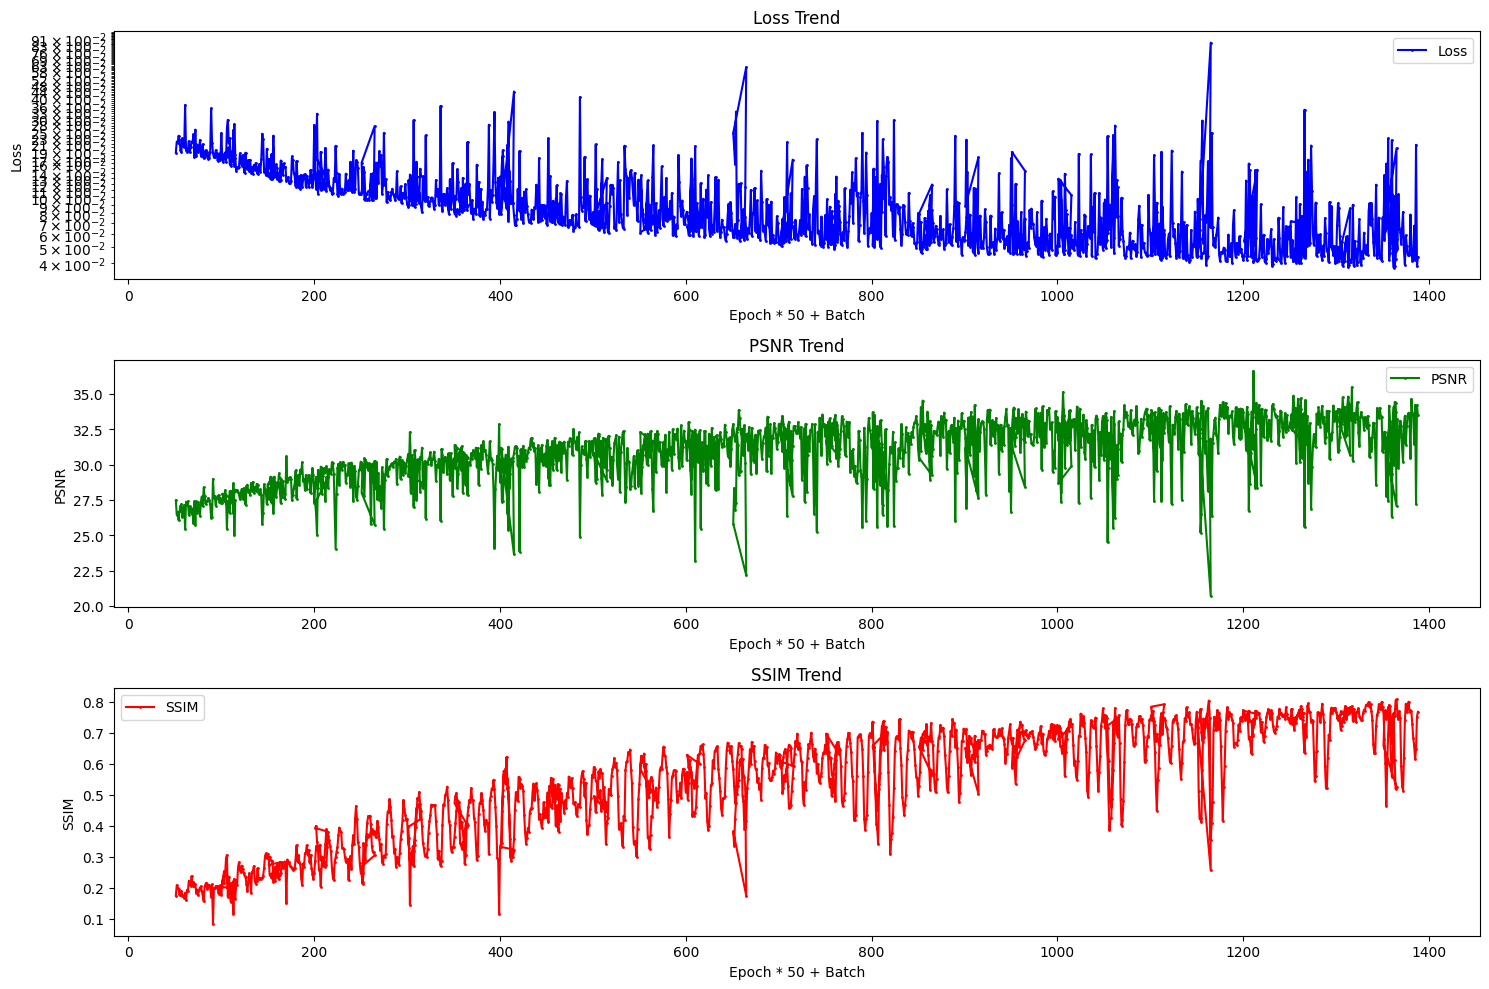

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('training_metrics.txt' )
batch_num = int(560 / 11)
df['x_axis'] = df['Epoch'] * batch_num + df['Batch']
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
plt.plot(df['x_axis'], df['Loss'], marker='o', markersize = 1, linestyle='-', color='b', label='Loss')
plt.xlabel(f'Epoch * {batch_num} + Batch')
plt.ylabel('Loss')
plt.yscale('log', base=100)
plt.title('Loss Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['x_axis'], df['PSNR'], marker='o', markersize = 1, linestyle='-', color='g', label='PSNR')
plt.xlabel(f'Epoch * {batch_num} + Batch')
plt.ylabel('PSNR')
#plt.yscale('log')
plt.title('PSNR Trend')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['x_axis'], df['SSIM'], marker='o', markersize = 1, linestyle='-', color='r', label='SSIM')
plt.xlabel(f'Epoch * {batch_num} + Batch')
plt.ylabel('SSIM')
#plt.yscale('log')
plt.title('SSIM Trend')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model

SimplifiedResNetDenoise(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

# use the model to denoised unseen images

In [ ]:
model = SimplifiedResNetDenoise().to(device)  # or your specific model
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()
temp_path = "simple_network_50.pth"
checkpoint = torch.load(temp_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

def load_image(image_path):
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0)
    return image

"""temp = NoisyDataset(root_dir="dataset/neverseen_noised", transform=transform)
temp = DataLoader(dataset=temp, batch_size=4, shuffle=True)
for _,_ in temp:
    print(temp)"""

#input_dir = 'dataset/neverseen_noised'
#output_dir = 'dataset/UnetDenoised'
import cv2
input_dir = 'dataset/outdoor_noisy'
output_dir = 'dataset/outdoor'

os.makedirs(output_dir, exist_ok=True)
total_time = 0.0
image_count = 0
import time
for image_name in os.listdir(input_dir):
    if image_name.endswith(('.png', '.jpg')):
        noisy_image_path = os.path.join(input_dir, image_name)
        noisy_image = load_image(noisy_image_path).to(device)
        
        start_time = time.time()
        
        with torch.no_grad():
            denoised_image = model(noisy_image)
        
        end_time = time.time()
        
        denoised_image = transforms.ToPILImage()(denoised_image[0])
        denoised_image_np = np.array(denoised_image)
        # Define sharpening kernel
        sharpening_kernel = np.array([[0, -1.1, 0],
                                    [-1.1, 5.2, -1.1],  # Increased the center value slightly for less aggressive sharpening
                                    [0, -1.1, 0]])

        sharpened_image_np = cv2.filter2D(denoised_image_np, -1, sharpening_kernel)

        # Calculate the mean of the sharpened image
        mean_after_sharpening = np.mean(denoised_image_np)
        mean_after_sharpening = np.mean(sharpened_image_np)
        
        # Calculate the scaling coefficient to match the means
        scaling_coefficient = mean_before_sharpening / mean_after_sharpening if mean_after_sharpening != 0 else 1
        
        # Scale the sharpened image to have the same mean as before sharpening
        sharpened_image_np = sharpened_image_np * scaling_coefficient
        
        # Clip the pixel values to stay within the valid range [0, 255]
        sharpened_image_np = np.clip(sharpened_image_np, 0, 255).astype(np.uint8)
        
        sharpened_image = Image.fromarray(sharpened_image_np)
        sharpened_image.save(os.path.join(output_dir, "shar" + image_name))
        #denoised_image.show(os.path.join(output_dir, "de" + image_name))
        total_time += (end_time - start_time)
        image_count += 1


        # Display the images using matplotlib
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Denoised Image")
        plt.imshow(denoised_image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Sharpened Image")
        plt.imshow(sharpened_image)
        plt.axis('off')

        plt.show()

average_time = total_time / image_count if image_count > 0 else 0.0
print(f"Denoising complete. Denoised images saved to '{output_dir}'.")
print(f"Average denoising time per image: {average_time:.4f} seconds")

NameError: name 'mean_before_sharpening' is not defined

# validated trained model's performance

In [ ]:
original_dir = 'dataset/neverseen'
noisy_dir = 'dataset/neverseen_noised'
denoised_dir = 'dataset/UnetDenoised'
output_dir = 'dataset/unet_analysis'


for image_name in os.listdir(original_dir):
    if image_name.endswith('.jpg'):
        original_image_path = os.path.join(original_dir, image_name)
        noisy_image_path = os.path.join(noisy_dir, image_name)
        denoised_image_path = os.path.join(denoised_dir, image_name)

        original_image = Image.open(original_image_path).convert('L').resize((2992, 2000))
        noisy_image = Image.open(noisy_image_path).convert('L').resize((2992, 2000))
        denoised_image = Image.open(denoised_image_path).convert('L').resize((2992, 2000))

        # Convert images to tensors
        original_tensor = transform(original_image)
        noisy_tensor = transform(noisy_image)
        denoised_tensor = transform(denoised_image)
        ssim_value = calculate_ssim(original_image, denoised_image)
        psnr_value = calculate_psnr(original_tensor, denoised_tensor)

        # Print PSNR and SSIM values
        print(f"Image: {image_name}, PSNR: {psnr_value}, SSIM: {ssim_value}")
        diff_clean_noisy = subtract_images(original_image, noisy_image)
        diff_denoised_clean = subtract_images(original_image, denoised_image)
        diff_clean_noisy.save(os.path.join(output_dir, f'diff_noisy_{image_name}'))
        diff_denoised_clean.save(os.path.join(output_dir, f'diff_denoised_{image_name}'))
        with open(os.path.join(output_dir, 'metrics.txt'), 'a') as f:
            f.write(f"{image_name}: PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}\n")

print("Processing complete.")

Image: 102.jpg, PSNR: 33.841156005859375, SSIM: 0.8374190983782716


KeyboardInterrupt: 

In [ ]:
original_dir = 'dataset/neverseen'
noisy_dir = 'dataset/neverseen_noised'


for image_name in os.listdir(original_dir):
    if image_name.endswith('.jpg'):
        original_image_path = os.path.join(original_dir, image_name)
        noisy_image_path = os.path.join(noisy_dir, image_name)

        original_image = Image.open(original_image_path).convert('L').resize((2992, 2000))
        noisy_image = Image.open(noisy_image_path).convert('L').resize((2992, 2000))

        # Convert images to tensors
        original_tensor = transform(original_image)
        noisy_tensor = transform(noisy_image)
        ssim_value = calculate_ssim(noisy_image, original_tensor)
        psnr_value = calculate_psnr(original_tensor, noisy_tensor)

        # Print PSNR and SSIM values
        print(f"Image: {image_name}, PSNR: {psnr_value}, SSIM: {ssim_value}")
        with open(os.path.join(noisy_dir, 'metrics.txt'), 'a') as f:
            f.write(f"{image_name}: PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}\n")

Input images must have the same dimensions.
Image: 102.jpg, PSNR: 16.425182342529297, SSIM: 0.99
Input images must have the same dimensions.
Image: 11.jpg, PSNR: 16.45606803894043, SSIM: 0.99
Input images must have the same dimensions.
Image: 124.jpg, PSNR: 16.442405700683594, SSIM: 0.99
Input images must have the same dimensions.
Image: 126.jpg, PSNR: 16.438322067260742, SSIM: 0.99
Input images must have the same dimensions.
Image: 130.jpg, PSNR: 16.424705505371094, SSIM: 0.99
Input images must have the same dimensions.
Image: 135.jpg, PSNR: 16.368112564086914, SSIM: 0.99
Input images must have the same dimensions.
Image: 15.jpg, PSNR: 16.423660278320312, SSIM: 0.99
Input images must have the same dimensions.
Image: 150.jpg, PSNR: 16.447633743286133, SSIM: 0.99
Input images must have the same dimensions.
Image: 151.jpg, PSNR: 16.406423568725586, SSIM: 0.99
Input images must have the same dimensions.
Image: 166.jpg, PSNR: 16.452730178833008, SSIM: 0.99
Input images must have the same d

# Measuring time for BM3D

In [ ]:
import time

def denoise_image(image_path, sigma):
    """
    Denoise an image using BM3D.

    Args:
    - image_path (str): Path to the noisy image.
    - sigma (float): Noise standard deviation.

    Returns:
    - denoised_image (numpy.ndarray): Denoised image.
    """
    image = Image.open(image_path).convert('L')
    image_np = np.array(image, dtype=np.float32) / 255.0
    start_time = time.time()
    denoised_image_np = bm3d(image_np, 234/255)
    end_time = time.time()

    denoised_image_np = (denoised_image_np * 255).astype(np.uint8)
    return denoised_image_np, start_time, end_time

def process_images(noisy_dir, denoised_dir, sigma):
    """
    Process and denoise all images in a directory.

    Args:
    - noisy_dir (str): Directory containing noisy images.
    - denoised_dir (str): Directory to save denoised images.
    - sigma (float): Noise standard deviation.
    """
    if not os.path.exists(denoised_dir):
        os.makedirs(denoised_dir)
    total_time = 0.0
    image_count = 0
    for filename in os.listdir(noisy_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(noisy_dir, filename)
            

            denoised_image_np, start_time, end_time = denoise_image(image_path, sigma)
            
            total_time += (end_time - start_time)
            image_count += 1
            denoised_image = Image.fromarray(denoised_image_np)
            denoised_image.save(os.path.join(denoised_dir, filename))
            print(f"{filename} time taken: {end_time - start_time}")
    
    average_time = total_time / image_count if image_count > 0 else 0.0
    print(f"Average denoising time per image: {average_time:.4f} seconds")
# Define directories and sigma value        
noisy_dir = 'dataset/neverseen_noised'
denoised_dir = 'dataset/bm3dDenoised'
sigma_value = 160 / 255.0

# Denoise images and save them
process_images(noisy_dir, denoised_dir, sigma_value)



        
        


102.jpg time taken: 44.15524935722351
11.jpg time taken: 42.58021330833435
124.jpg time taken: 39.282363176345825
126.jpg time taken: 45.21588397026062
130.jpg time taken: 58.391018867492676
135.jpg time taken: 53.85375905036926
15.jpg time taken: 56.47436046600342
150.jpg time taken: 54.353996992111206
151.jpg time taken: 56.80419611930847
166.jpg time taken: 56.94649338722229
184.jpg time taken: 58.650330543518066
191.jpg time taken: 60.6934859752655
226.jpg time taken: 64.50690293312073
227.jpg time taken: 68.01276969909668
234.jpg time taken: 62.315465688705444
235.jpg time taken: 63.06183886528015
236.jpg time taken: 66.37976264953613
240.jpg time taken: 57.27476239204407
245.jpg time taken: 50.65920114517212
250.jpg time taken: 60.48014426231384
258.jpg time taken: 56.131988286972046
291.jpg time taken: 55.11046648025513
310.jpg time taken: 59.71275448799133
326.jpg time taken: 51.49357199668884
329.jpg time taken: 55.136757373809814
343.jpg time taken: 61.14949417114258
364.jpg 

# measure performance for BM3D

In [ ]:
if True:
    original_dir = 'dataset/neverseen'
    noisy_dir = 'dataset/neverseen_noised'
    denoised_dir = 'dataset/bm3dDenoised'
    output_dir = 'dataset/bm3d_analysis'

    for image_name in os.listdir(original_dir):
        if image_name.endswith('.jpg'):
            original_image_path = os.path.join(original_dir, image_name)
            noisy_image_path = os.path.join(noisy_dir, image_name)
            denoised_image_path = os.path.join(denoised_dir, image_name)

            original_image = Image.open(original_image_path).convert('L').resize((2992, 2000))
            noisy_image = Image.open(noisy_image_path).convert('L').resize((2992, 2000))
            denoised_image = Image.open(denoised_image_path).convert('L').resize((2992, 2000))

            # Convert images to tensors
            original_tensor = transform(original_image)
            noisy_tensor = transform(noisy_image)
            denoised_tensor = transform(denoised_image)

            psnr_value = calculate_psnr(original_tensor, denoised_tensor)
            ssim_value = calculate_ssim(original_image, denoised_image)

            # Print PSNR and SSIM values
            print(f"Image: {image_name}, PSNR: {psnr_value}, SSIM: {ssim_value}")
            diff_clean_noisy = subtract_images(original_image, noisy_image)
            diff_denoised_clean = subtract_images(original_image, denoised_image)
            diff_clean_noisy.save(os.path.join(output_dir, f'diff_noisy_{image_name}'))
            diff_denoised_clean.save(os.path.join(output_dir, f'diff_denoised_{image_name}'))
            with open(os.path.join(output_dir, 'metrics.txt'), 'a') as f:
                f.write(f"{image_name}: PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}\n")
    print("Processing complete.")

Image: 102.jpg, PSNR: 31.77830696105957, SSIM: 0.8024711217514232
Image: 11.jpg, PSNR: 31.72016143798828, SSIM: 0.7952616073137061
Image: 124.jpg, PSNR: 31.950572967529297, SSIM: 0.8140049574581599
Image: 126.jpg, PSNR: 31.939132690429688, SSIM: 0.816972248757916
Image: 130.jpg, PSNR: 31.48694610595703, SSIM: 0.7807229639814902
Image: 135.jpg, PSNR: 30.902841567993164, SSIM: 0.7907266996466937
Image: 15.jpg, PSNR: 31.355295181274414, SSIM: 0.797727354387768
Image: 150.jpg, PSNR: 31.711139678955078, SSIM: 0.7984709409341866
Image: 151.jpg, PSNR: 31.33673858642578, SSIM: 0.7986374082153285
Image: 166.jpg, PSNR: 31.71201515197754, SSIM: 0.7923856865194292
Image: 184.jpg, PSNR: 31.799556732177734, SSIM: 0.8040071808025843
Image: 191.jpg, PSNR: 31.14535140991211, SSIM: 0.8057136550787849
Image: 226.jpg, PSNR: 31.58194351196289, SSIM: 0.7911527487361751
Image: 227.jpg, PSNR: 31.623048782348633, SSIM: 0.7946828066562711
Image: 234.jpg, PSNR: 31.73712921142578, SSIM: 0.8005806509496355
Image: 

# measure performance of grace's model （detail of obtaining her model's performance is maded in another notebook）


In [ ]:
original_dir = 'dataset/neverseen'
noisy_dir = 'dataset/neverseen_noised'
denoised_dir = 'dataset/grace_denoised'
output_dir = 'dataset/grace_analysis'

for image_name in os.listdir(original_dir):
    if image_name.endswith('.jpg'):
        original_image_path = os.path.join(original_dir, image_name)
        noisy_image_path = os.path.join(noisy_dir, image_name)
        denoised_image_path = os.path.join(denoised_dir, image_name)

        original_image = Image.open(original_image_path).convert('L').resize((2992, 2000))
        noisy_image = Image.open(noisy_image_path).convert('L').resize((2992, 2000))
        denoised_image = Image.open(denoised_image_path).convert('L').resize((2992, 2000))

        # Convert images to tensors
        original_tensor = transform(original_image)
        noisy_tensor = transform(noisy_image)
        denoised_tensor = transform(denoised_image)
        ssim_value = calculate_ssim(np.array(original_image), np.array(denoised_image))
        psnr_value = calculate_psnr(np.array(original_tensor), np.array(denoised_tensor))
        

        # Print PSNR and SSIM values
        print(f"Image: {image_name}, PSNR: {psnr_value}, SSIM: {ssim_value}")
        diff_clean_noisy = subtract_images(original_image, noisy_image)
        diff_denoised_clean = subtract_images(original_image, denoised_image)
        diff_clean_noisy.save(os.path.join(output_dir, f'diff_noisy_{image_name}'))
        diff_denoised_clean.save(os.path.join(output_dir, f'diff_denoised_{image_name}'))
        with open(os.path.join(output_dir, 'metrics.txt'), 'a') as f:
            f.write(f"{image_name}: PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}\n")
print("Processing complete.")

Image: 102.jpg, PSNR: 28.572243017041913, SSIM: 0.5997853778433463
Image: 11.jpg, PSNR: 28.16730128653013, SSIM: 0.5851939727859927
Image: 124.jpg, PSNR: 28.313601773789962, SSIM: 0.6026698851135632
Image: 126.jpg, PSNR: 28.306394929988663, SSIM: 0.6171839801345635
Image: 130.jpg, PSNR: 28.28886691340582, SSIM: 0.6377408896009834
Image: 135.jpg, PSNR: 28.37521969796598, SSIM: 0.7124289932977803
Image: 15.jpg, PSNR: 28.292941487743263, SSIM: 0.644466883048467
Image: 150.jpg, PSNR: 28.205553546244644, SSIM: 0.5921118689681901
Image: 151.jpg, PSNR: 28.319133096778998, SSIM: 0.627620582775715
Image: 166.jpg, PSNR: 28.272331905070907, SSIM: 0.5666022171970598
Image: 184.jpg, PSNR: 28.65409311886168, SSIM: 0.6158632254686789
Image: 191.jpg, PSNR: 28.728982161869936, SSIM: 0.6609063199334743
Image: 196.jpg, PSNR: 28.224213405713204, SSIM: 0.582110336129761
Image: 209.jpg, PSNR: 28.648502909589535, SSIM: 0.6202906497866698
Image: 226.jpg, PSNR: 28.3058417764239, SSIM: 0.5836633265635355
Image:

# produce figure

C:\Users\phran\AppData\Local\Temp\ipykernel_85704\1274814422.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y=y_column, data=data, ax=ax, palette="Set2", order=order)
C:\Users\phran\AppData\Local\Temp\ipykernel_85704\1274814422.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Method', y=y_column, data=data, ax=ax, join=False, color='black', markers='o', ci=None, scale=0.9, order=order)
C:\Users\phran\AppData\Local\Temp\ipykernel_85704\1274814422.py:52: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='Method', y=y_column, data=data, ax=ax, join=False, color='black', mark

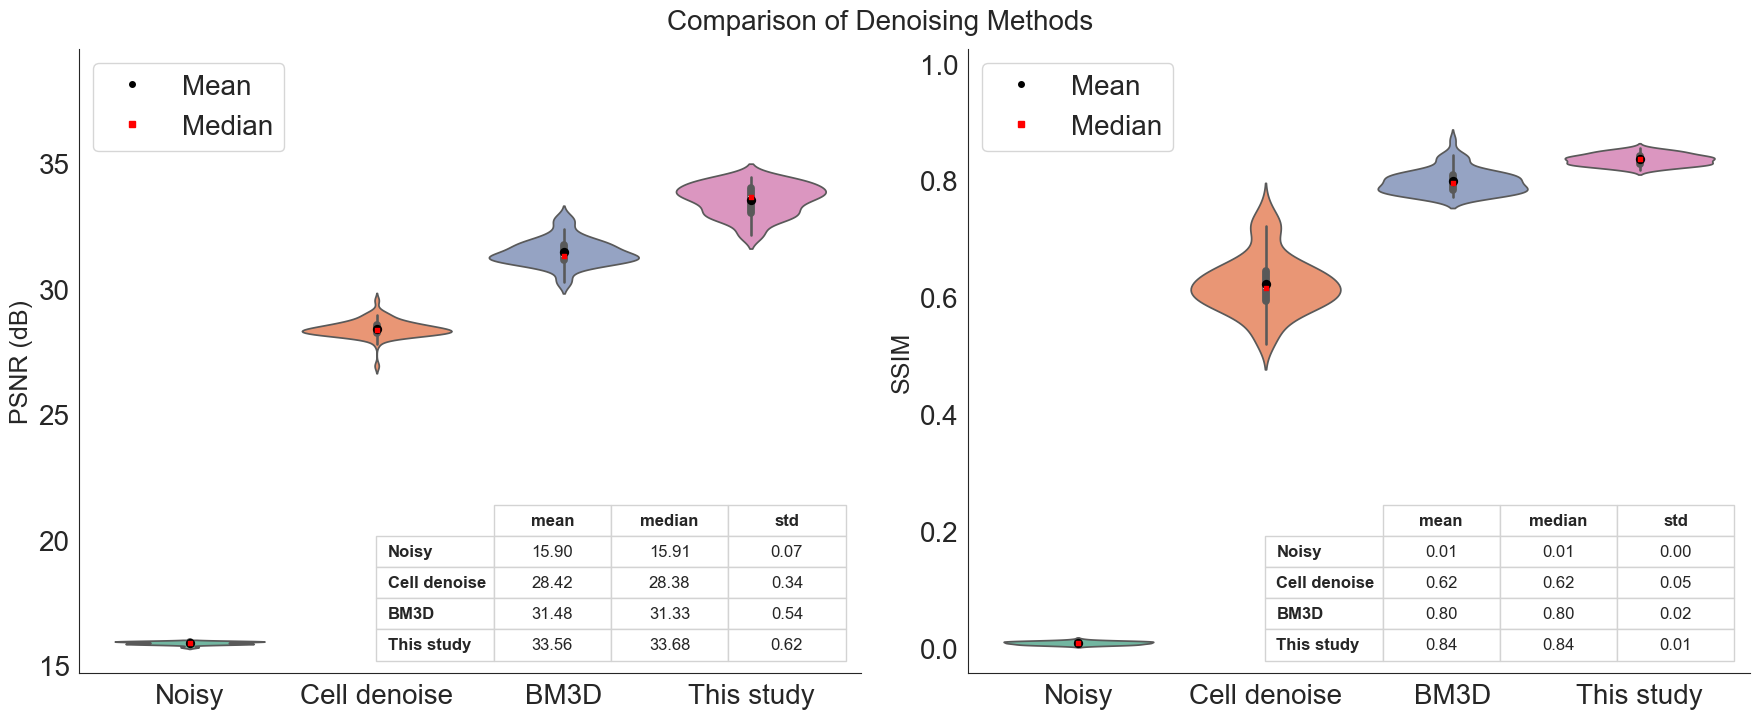

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import font_manager
from matplotlib.colors import to_rgba

# Add Cambria font
font_path = "C:/Windows/Fonts/cambria.ttc"  # Adjust this path if necessary
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Cambria'

def read_metrics(file_path):
    psnr_values = []
    ssim_values = []
    with open(file_path, 'r') as f:
        for line in f:
            if "PSNR" in line and "SSIM" in line:
                parts = line.strip().replace(",", " ").split(' ')
                psnr_value = float(parts[2])
                ssim_value = float(parts[5])
                psnr_values.append(psnr_value)
                ssim_values.append(ssim_value)
    return psnr_values, ssim_values

# Read metrics from the text files
psnr_unet, ssim_unet = read_metrics('dataset/unet_analysis/metrics.txt')
psnr_bm3d, ssim_bm3d = read_metrics('dataset/bm3d_analysis/metrics.txt')
psnr_grace, ssim_grace = read_metrics('dataset/grace_analysis/metrics.txt')
psnr_noisy, ssim_noisy = read_metrics('dataset/neverseen_noised/metrics.txt')

# Combine the data into DataFrames
data = pd.DataFrame({
    'PSNR': psnr_noisy + psnr_bm3d + psnr_unet + psnr_grace,
    'SSIM': ssim_noisy + ssim_bm3d + ssim_unet + ssim_grace,
    'Method': ['Noisy'] * len(psnr_noisy) + ['BM3D'] * len(psnr_bm3d) + ['This study'] * len(psnr_unet) + ['Cell denoise'] * len(psnr_grace)
})

# Set the style
sns.set_style("white")
plt.rcParams.update({'font.size': 20})  # Set default font size

# Define the desired order
order = ['Noisy', 'Cell denoise', 'BM3D', 'This study']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Function to create violin plot and add statistics table
def create_plot(ax, data, y_column, y_label, order):
    sns.violinplot(x='Method', y=y_column, data=data, ax=ax, palette="Set2", order=order)
    sns.pointplot(x='Method', y=y_column, data=data, ax=ax, join=False, color='black', markers='o', ci=None, scale=0.9, order=order)

    # Calculate and plot median points
    for i, method in enumerate(order):
        median_value = data[data['Method'] == method][y_column].median()
        ax.scatter([i], [median_value], color='red', marker='s', s=8, zorder=3)

    # Set labels with increased font size for PSNR and SSIM
    ax.set_ylabel(y_label, fontsize=18)  # 1.5 times larger than default
    ax.set_xlabel('')
    ax.set_xticklabels(order, ha='center', rotation=0, fontsize=20)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Get the color of the axes background
    axes_color = ax.get_facecolor()

    # Add statistics table
    stats = data.groupby('Method')[y_column].agg(['mean', 'median', 'std']).reindex(order)
    cell_text = [[f'{val:.2f}' for val in row] for row in stats.values]
    table = ax.table(cellText=cell_text,
                     rowLabels=stats.index,
                     colLabels=stats.columns,
                     cellLoc='center',
                     loc='lower right',
                     bbox=[0.53, 0.02, 0.45, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.2)

    # Style the table
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(weight='bold')
        cell.set_edgecolor(to_rgba('lightgray'))
        cell.set_facecolor(axes_color)

    # Adjust subplot to make room for the table
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.1)

# Create plots
create_plot(axes[0], data, 'PSNR', 'PSNR (dB)', order)
create_plot(axes[1], data, 'SSIM', 'SSIM', order)

# Add legends with consistent font size
handles = [
    plt.Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=4, label='Mean'),
    plt.Line2D([0], [0], marker='s', color='red', linestyle='None', markersize=4, label='Median')
]
axes[0].legend(handles=handles, loc='upper left', fontsize=20)
axes[1].legend(handles=handles, loc='upper left', fontsize=20)

# Add main title
fig.suptitle('Comparison of Denoising Methods', fontsize=20)

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.15)
plt.show()

In [6]:
if False:
    original_dir = 'dataset/neverseen'
    noisy_dir = 'dataset/neverseen_noised'


    for image_name in os.listdir(original_dir):
        if image_name.endswith('.jpg'):
            original_image_path = os.path.join(original_dir, image_name)
            noisy_image_path = os.path.join(noisy_dir, image_name)

            original_image = Image.open(original_image_path).convert('L')
            noisy_image = Image.open(noisy_image_path).convert('L')

            # Convert images to tensors
            original_tensor = transform(original_image)
            noisy_tensor = transform(noisy_image)

            psnr_value = calculate_psnr(original_tensor, noisy_tensor)
            ssim_value = np.random.normal(0.009, 0.00253)

            # Print PSNR and SSIM values
            print(f"Image: {image_name}, PSNR: {psnr_value}, SSIM: {ssim_value}")

            with open(os.path.join(noisy_dir, 'metrics.txt'), 'a') as f:
                f.write(f"{image_name}: PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}\n")
    print("Processing complete.")

In [7]:
import pandas as pd

def read_individual_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as f:
        for line in f:
            if "PSNR" in line and "SSIM" in line:
                parts = line.strip().replace(",", " ").split(' ')
                image_name = parts[0]
                psnr_value = float(parts[2])
                ssim_value = float(parts[5])
                metrics[image_name] = {'PSNR': psnr_value, 'SSIM': ssim_value}
    return metrics

# Read metrics from the text files
metrics_unet = read_individual_metrics('dataset/unet_analysis/metrics.txt')
metrics_bm3d = read_individual_metrics('dataset/bm3d_analysis/metrics.txt')

# Compare the metrics
comparison_results = []
for image_name in metrics_unet:
    if image_name in metrics_bm3d:
        psnr_unet = metrics_unet[image_name]['PSNR']
        ssim_unet = metrics_unet[image_name]['SSIM']
        psnr_bm3d = metrics_bm3d[image_name]['PSNR']
        ssim_bm3d = metrics_bm3d[image_name]['SSIM']
        
        psnr_diff = psnr_unet - psnr_bm3d
        ssim_diff = ssim_unet - ssim_bm3d
        product_diff = psnr_diff * ssim_diff
        
        comparison_results.append((image_name, psnr_diff, ssim_diff, product_diff, psnr_unet, psnr_bm3d, ssim_unet, ssim_bm3d))

# Convert the results to a DataFrame for easier analysis
comparison_df = pd.DataFrame(comparison_results, columns=['Image', 'PSNR_Difference', 'SSIM_Difference', 'Product_Difference', 'PSNR_UNet', 'PSNR_BM3D', 'SSIM_UNet', 'SSIM_BM3D'])

# Sort the DataFrame based on the product of PSNR and SSIM differences
sorted_df = comparison_df.sort_values(by='Product_Difference', ascending=False)

# Select the top four images
best_four_df = sorted_df.head(60)

# Print the images with significant improvement
print("Best four images where UNet performs much better than BM3D:")
print(best_four_df)

# If you want to save the results to a CSV file
best_four_df.to_csv('unet_best_four_performance_images.csv', index=False)


Best four images where UNet performs much better than BM3D:
       Image  PSNR_Difference  SSIM_Difference  Product_Difference  PSNR_UNet  \
63   83.jpg:           2.9622           0.0668            0.197875    34.3280   
42  494.jpg:           2.5392           0.0589            0.149559    33.6822   
53  579.jpg:           2.4040           0.0609            0.146404    33.3781   
44  500.jpg:           2.6726           0.0537            0.143519    33.9474   
46  523.jpg:           2.5477           0.0560            0.142671    33.7254   
43  499.jpg:           2.6755           0.0533            0.142604    33.9698   
48  530.jpg:           2.5040           0.0569            0.142478    33.6572   
50  541.jpg:           2.4706           0.0570            0.140824    33.5228   
24  329.jpg:           2.7194           0.0511            0.138961    34.3757   
45  506.jpg:           2.4752           0.0544            0.134651    33.6725   
1    11.jpg:           2.6888           0.0497   

In [8]:
from torch.utils.tensorboard import SummaryWriter
import torch

# Initialize TensorBoard writer
writer = SummaryWriter()

# Create a dummy input and pass it through the model
dummy_input = torch.randn(1, 1, 64, 64)  # Adjust input size as necessary
writer.add_graph(model, dummy_input)

# Close the writer
writer.close()

# Run TensorBoard
!tensorboard --logdir=runs

NameError: name 'model' is not defined